In this demonstration we use the proposed model to extract melody for a wav file, then display the extracted melody, as well as the melodies extracted by some other state-of-the-art models.

In [38]:
import logging
logging.basicConfig(level=logging.INFO)
import IPython
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import librosa.display
from main import MetricsBase
from self_defined import load_np_array_from_file_fn

for name in logging.root.manager.loggerDict:
    if name.startswith('numba'):
        logger = logging.getLogger(name)
        logger.setLevel(logging.WARNING)

    if name.startswith('matplotlib'):
        logger = logging.getLogger(name)
        logger.setLevel(logging.WARNING)

    if name.startswith('numpy'):
        logger = logging.getLogger(name)
        logger.setLevel(logging.WARNING)
        
%matplotlib inline 

In [39]:
# the example wav file is from the MIR-1K dataset
track_id_from_mir_1k = 'abjones_1_01'
wav_file = os.path.join(os.environ['mir1k'], 'Wavfile', track_id_from_mir_1k + '.wav')
IPython.display.Audio(wav_file)

In [40]:
from main import TFDatasetForMir1k  
# TFDatasetForMir1k is class containing many utilities for managing the MIR-1K dataset 

First we show the ground-truth melody of this wav file.

In [41]:
ground_truth_labels = TFDatasetForMir1k.gen_label_fn(track_id_from_mir_1k)['notes']
ground_truth_times = np.arange(len(ground_truth_labels)) * (256. / 44100)  # hop size 256 samples at sr 44100

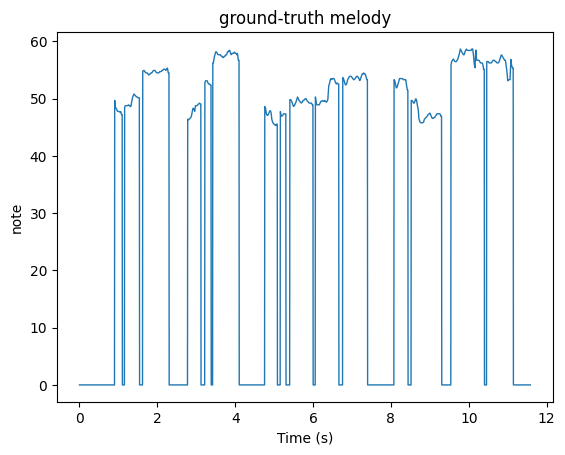

In [42]:
plt.plot(ground_truth_times, ground_truth_labels, linewidth='1')
plt.title('ground-truth melody')
plt.xlabel('Time (s)')
plt.ylabel('note')
plt.show()

Now we use the proposed model to extract the melody

In [18]:
import tensorflow as tf
import pitch_local as acoustic_model_module  # the model is defined in pitch_local

In [19]:
keras_acoustic_model = acoustic_model_module.create_acoustic_model_fn()  # create a keras model
tf_var_voicing_threshold = tf.Variable(.15, trainable=False, name='voicing_threshold')  # container for the voicing threshold

Next we load the saved checkpoint of the model

In [43]:
model_for_ckpt = dict(acoustic_model=keras_acoustic_model, voicing_threshold=tf_var_voicing_threshold)
ckpt_file = 'ckpts/d0-24'
ckpt = tf.train.Checkpoint(model=model_for_ckpt)
status = ckpt.restore(ckpt_file)
status.expect_partial()
status.assert_existing_objects_matched()
print(tf_var_voicing_threshold)  # now the voicing threshold has changed

<tf.Variable 'voicing_threshold:0' shape=() dtype=float32, numpy=0.33>


Before running the model we need to generate the spectrogram.

In [44]:
spectrogram = TFDatasetForMir1k.gen_spec_fn(track_id_from_mir_1k)
print(spectrogram.shape)

(2002, 500)


Let's see how the spectrogram looks like.

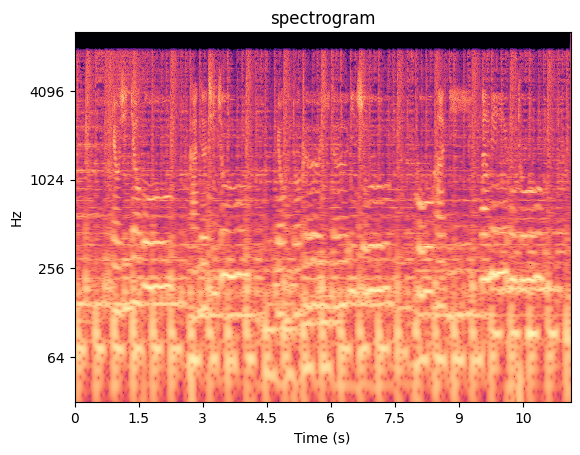

In [45]:
librosa.display.specshow(
    spectrogram.T,
    x_axis='time',
    y_axis='cqt_hz',
    fmin=librosa.midi_to_hz(23.6),
    bins_per_octave=60,
    hop_length=256,
    sr=44100
)
plt.title('spectrogram')
plt.xlabel('Time (s)')
plt.show()

We define a tf function that can convert logits to melody notes.

In [27]:
@tf.function(
    input_signature=[tf.TensorSpec([None, 320], name='logits')]
)
def logits_to_notes_fn(logits):

    voicing_threshold = tf_var_voicing_threshold
    logits = tf.convert_to_tensor(logits, tf.float32)
    logits.set_shape([None, 320])

    est_probs = tf.sigmoid(logits)
    est_peak_indices = tf.argmax(est_probs, axis=1, output_type=tf.int32)
    est_peak_probs = tf.gather_nd(est_probs, est_peak_indices[:, None], batch_dims=1)
    est_voicing = est_peak_probs > voicing_threshold
    est_voicing.set_shape([None])
    est_notes = MetricsBase.est_notes_fn(est_peak_indices=est_peak_indices, est_probs=est_probs)
    est_notes_with_voicing_info = tf.where(est_voicing, est_notes, 0.)

    return est_notes_with_voicing_info

Finally we can run the model to extract the melody.

In [32]:
pred_notes = []
snippet_len = 1200  # each example has 1200 frames
num_frames = len(spectrogram)
num_snippets = (num_frames + snippet_len - 1) // snippet_len
for snippet_idx in range(num_snippets):
    start_frame = snippet_idx * snippet_len
    end_frame = start_frame + snippet_len
    spec = spectrogram[start_frame:end_frame]
    logits = keras_acoustic_model(spec[None, ...], training=False)
    _pred_notes = logits_to_notes_fn(logits)
    pred_notes.append(_pred_notes.numpy())
pred_notes = np.concatenate(pred_notes)
assert len(pred_notes) == num_frames

Below we show the extracted melody.

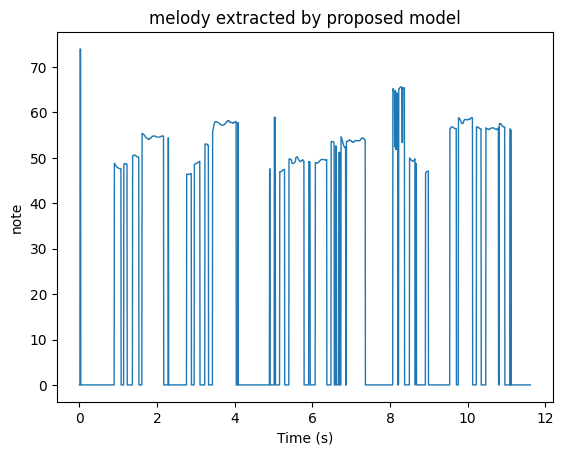

In [34]:
times = np.arange(num_frames) * (256. / 44100)
plt.title('melody extracted by proposed model')
plt.plot(times, pred_notes, linewidth='1')
plt.xlabel('Time (s)')
plt.ylabel('note')
plt.show()

For comparison we also show the melodies extracted by some up-to-date models:
- [kknet] K. Shao, K. Chen, T. Berg-Kirkpatrick, and S. Dubnov, “Towards improving harmonic sensitivity and prediction stability for singing melody extraction,” in Proc. Int. Soc. Music Inf. Retriev. Conf., 2023, pp. 1–7.
- [mtanet] Y. Gao, Y. Hu, L. Wang, H. Huang, and L. He, “MTANet: Multi-band time-frequency attention network for singing melody extraction from polyphonic music,” in Proc. INTERSPEECH, 2023, pp. 5396–5400.
- [rmvpe] H. Wei, X. Cao, T. Dan, and Y. Chen, “RMVPE: A robust model for vocal pitch estimation in polyphonic music,” in Proc. INTERSPEECH, 2023, pp. 5421–5425.

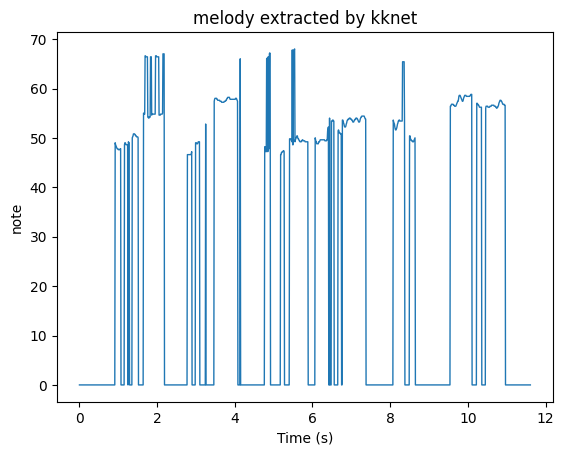

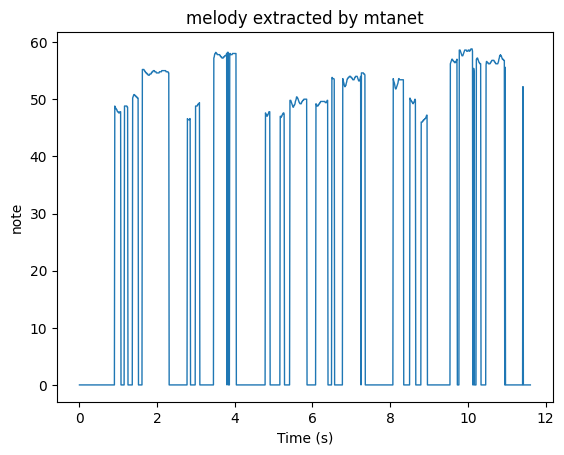

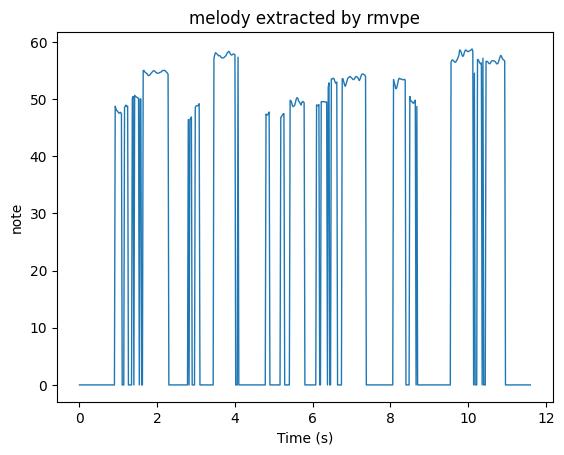

In [37]:
for model_name in ('kknet', 'mtanet', 'rmvpe'):
    melody_file = track_id_from_mir_1k + '_{}_melody.dat'.format(model_name)
    melody_file = os.path.join('predicted_melody', melody_file)
    rec_name, times_notes = load_np_array_from_file_fn(melody_file)
    assert rec_name == track_id_from_mir_1k
    plt.plot(times_notes[:, 0], times_notes[:, 1], linewidth='1')
    plt.title('melody extracted by {}'.format(model_name))
    plt.xlabel('Time (s)')
    plt.ylabel('note')
    plt.show()